# Healthcare Analytics Project #
### Introduction ###
The goal of this project is to predict the length of stay of a patient in a hospital. The length of stay is given in 11 categories from 0-10 days to 100+ days, therefore it is a classification problem. I will use random forest model, because it is powerful enough to do well witch fairly complicated problems while it still has quite managable hyperregulation.

The data is taken from: https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii


In [24]:
#Imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Importing datasets
train_data = pd.read_csv("raw_data/train_data.csv")
data_dictionary = pd.read_csv("raw_data/train_data_dictionary.csv")

### Exploratory Data Analysis ### 
I have imported the train set only, because the test set has no 'Stay' values (labels) therefore it is worthless for a project which isn't a contest entry. 

Let's start by viewing the data and data description.

In [3]:
train_data

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


In [4]:
data_dictionary

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


Before we move on let's convert age and stay values from range categories (1-10, 11-20 etc) to numeric categories. It will come in handy when creating distribution plots, and is necessary for modelling.

In [5]:
def categoryConverter(df, column, values, newCat):
    """
    This function converts values in a pandas dataframe
    
    Parameters:
    df: pandas dataframe
    column: name of column in which values will be changed
    values: a list of old values to be replaced
    newCat: list of new values. Must be the same length as 'values' parameter.
    """
    
    for idx, val in enumerate(values):
        df.loc[df[column] == val, column] = newCat[idx]

#First use the function od train_data for EDA
values = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','More than 100 Days']
newCat = list(range(0,len(values)))
categoryConverter(train_data, 'Stay', values, newCat)
train_data.Stay.unique() #To check if all categories got replaced

array([0, 4, 3, 1, 5, 2, 7, 10, 8, 6, 9], dtype=object)

In [6]:
#And let's use it on Age column. I've shown how the function works and how the parameters should look above, so this time I'll use quicker method of creating the 'values' list
values = list(train_data.Age.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(train_data, 'Age', values, newCat)
train_data.Age.unique() #Once again to check if the function worked

array([5, 7, 3, 4, 8, 6, 2, 1, 0, 9], dtype=object)

Now let's see the distribution of hospitals and cases by hospital parameters.

Text(0.5, 1.0, 'Distribution of hospitals by type')

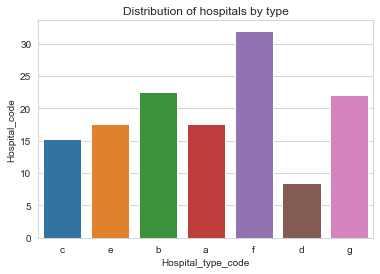

In [7]:
sns.set_style('whitegrid')
sns.barplot(y= train_data['Hospital_code'], x = train_data['Hospital_type_code'],ci=None).set_title("Distribution of hospitals by type")

Text(0.5, 1.0, 'Distribution of hospitals by city code')

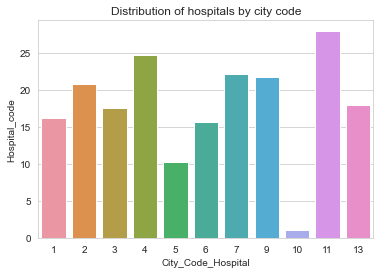

In [8]:
sns.barplot(y= train_data['Hospital_code'], x = train_data['City_Code_Hospital'],ci=None).set_title("Distribution of hospitals by city code")

Text(0.5, 1.0, 'Distribution of hospitals by region')

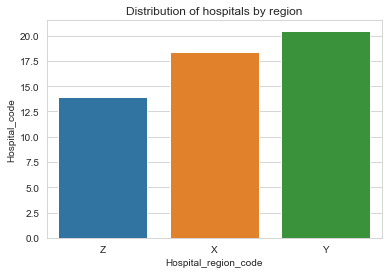

In [9]:
sns.barplot(y= train_data['Hospital_code'], x = train_data['Hospital_region_code'], ci=None).set_title("Distribution of hospitals by region")

Text(0.5, 1.0, 'Distribution of cases by hospital id')

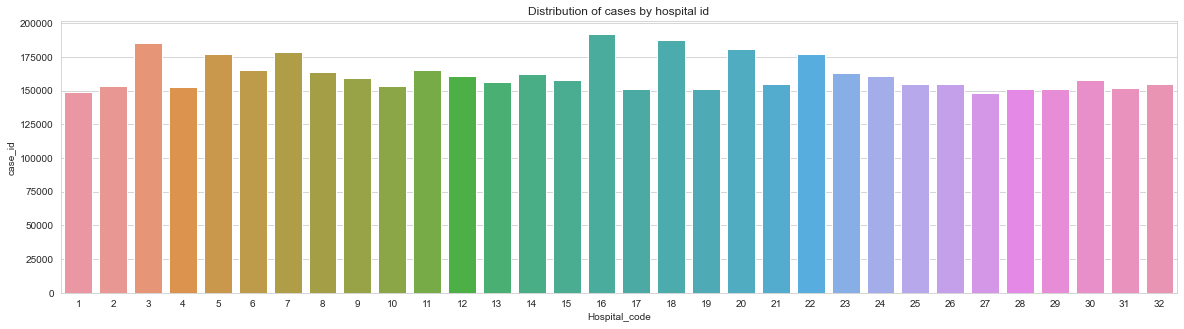

In [10]:
plt.figure(figsize=(20,5))
sns.barplot(y= train_data['case_id'], x = train_data['Hospital_code'], ci=None).set_title("Distribution of cases by hospital id")

Text(0.5, 1.0, 'Distribution of cases by hospital city code')

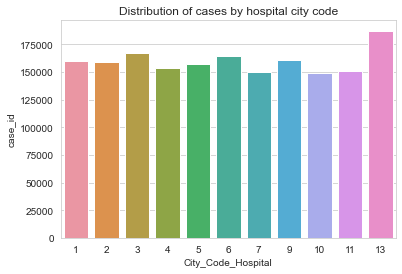

In [11]:
sns.barplot(y= train_data['case_id'], x = train_data['City_Code_Hospital'], ci=None).set_title("Distribution of cases by hospital city code")

Text(0.5, 1.0, 'Distribution of cases by hospital region')

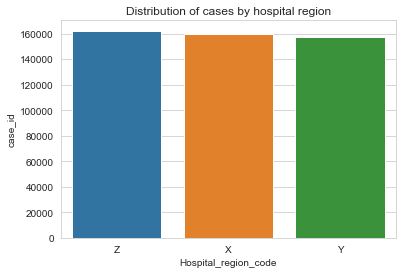

In [12]:
sns.barplot(y= train_data['case_id'], x = train_data['Hospital_region_code'], ci=None).set_title("Distribution of cases by hospital region")

Text(0.5, 1.0, 'Distribution of cases by hospital type')

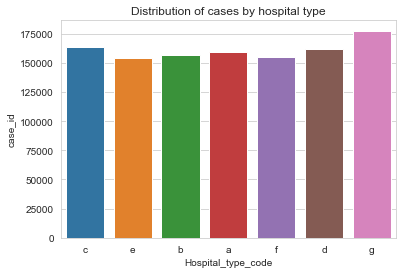

In [13]:
sns.barplot(y= train_data['case_id'], x = train_data['Hospital_type_code'], ci=None).set_title("Distribution of cases by hospital type")

Text(0.5, 1.0, 'Distribution of cases by available rooms')

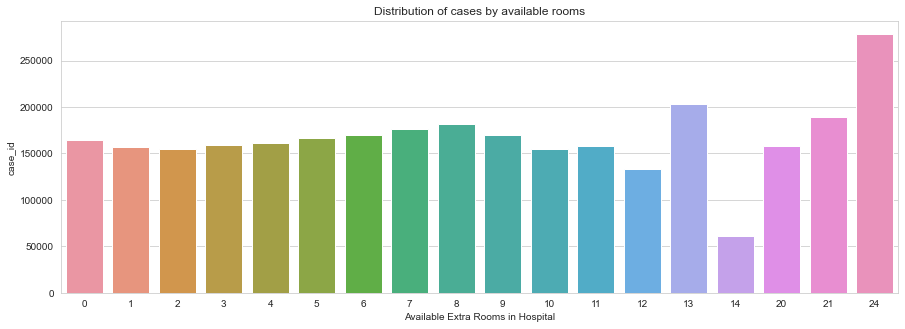

In [14]:
plt.figure(figsize=(15,5))
sns.barplot(y= train_data['case_id'], x = train_data['Available Extra Rooms in Hospital'], ci=None).set_title("Distribution of cases by available rooms")

Now we'll analyze the department and ward related data, this time as a subplot matrix.

Text(0.5, 1.0, 'Distribution of cases by bed grade')

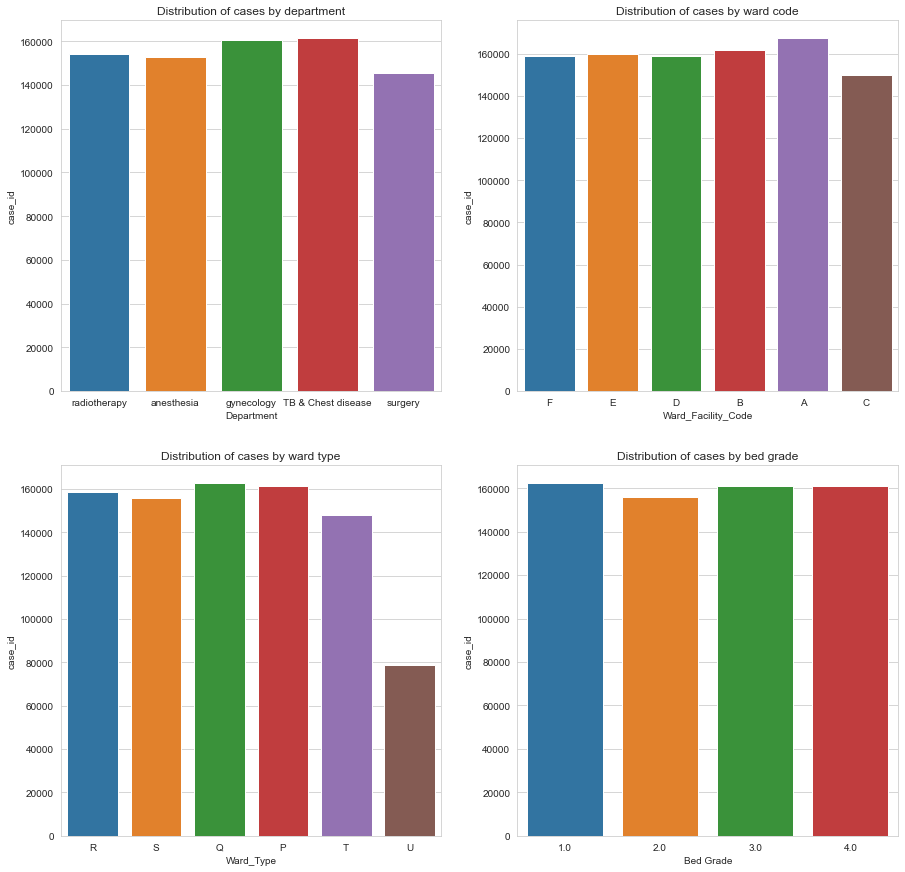

In [15]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.barplot(y= train_data['case_id'], x = train_data['Department'], ci=None).set_title("Distribution of cases by department")
plt.subplot(2,2,2)
sns.barplot(y= train_data['case_id'], x = train_data['Ward_Facility_Code'], ci=None).set_title("Distribution of cases by ward code")
plt.subplot(2,2,3)
sns.barplot(y= train_data['case_id'], x = train_data['Ward_Type'], ci=None).set_title("Distribution of cases by ward type")
plt.subplot(2,2,4)
sns.barplot(y= train_data['case_id'], x = train_data['Bed Grade'], ci=None).set_title("Distribution of cases by bed grade")


And finally we'll move on to the patient related data.

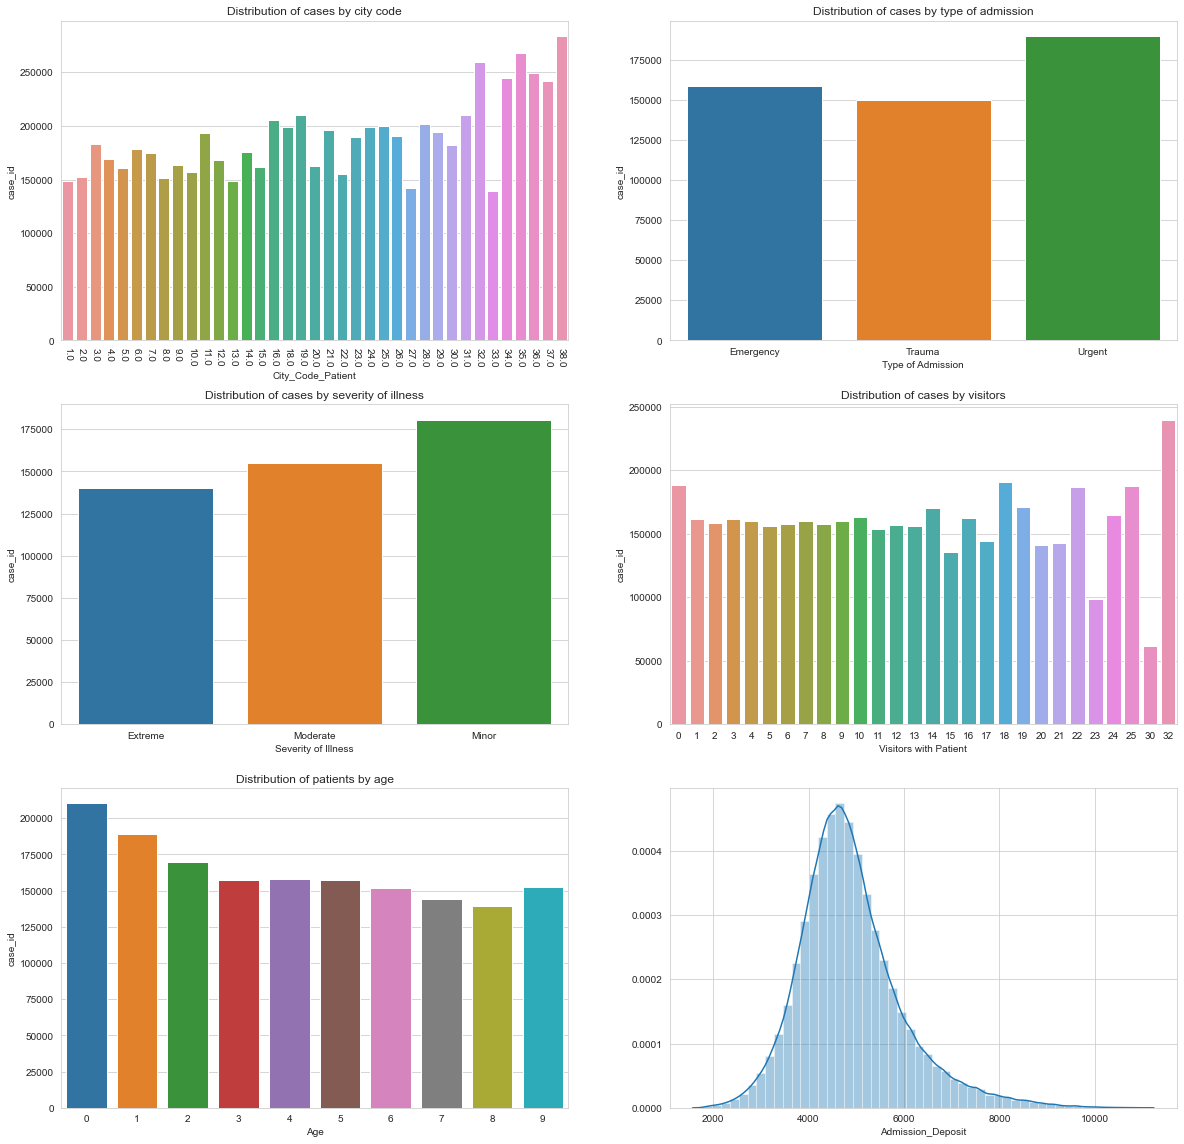

In [16]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
sns.barplot(y= train_data['case_id'], x = train_data['City_Code_Patient'], ci=None).set_title("Distribution of cases by city code")
plt.xticks(rotation=-90)
plt.subplot(3,2,2)
sns.barplot(y= train_data['case_id'], x = train_data['Type of Admission'], ci=None).set_title("Distribution of cases by type of admission")
plt.subplot(3,2,3)
sns.barplot(y= train_data['case_id'], x = train_data['Severity of Illness'], ci=None).set_title("Distribution of cases by severity of illness")
plt.subplot(3,2,4)
sns.barplot(y= train_data['case_id'], x = train_data['Visitors with Patient'], ci=None).set_title("Distribution of cases by visitors")
plt.subplot(3,2,5)
sns.barplot(y= train_data['case_id'], x = train_data['Age'], ci=None).set_title("Distribution of patients by age")
plt.subplot(3,2,6)
sns.distplot(train_data['Admission_Deposit'])

**Note:** Without the category type change we did in the beginnning the age graph would be dizorganized, because age categories would be sorted by the order in which they appear in the dataset, not by increasing values.


And one final big distribution matrix of length of stay by all parameters (except case ID and patient ID). This time without category type conversion some graphs would cause error of lack of numerical values.

Text(0.5, 1.0, 'Distribution of LoS by age')

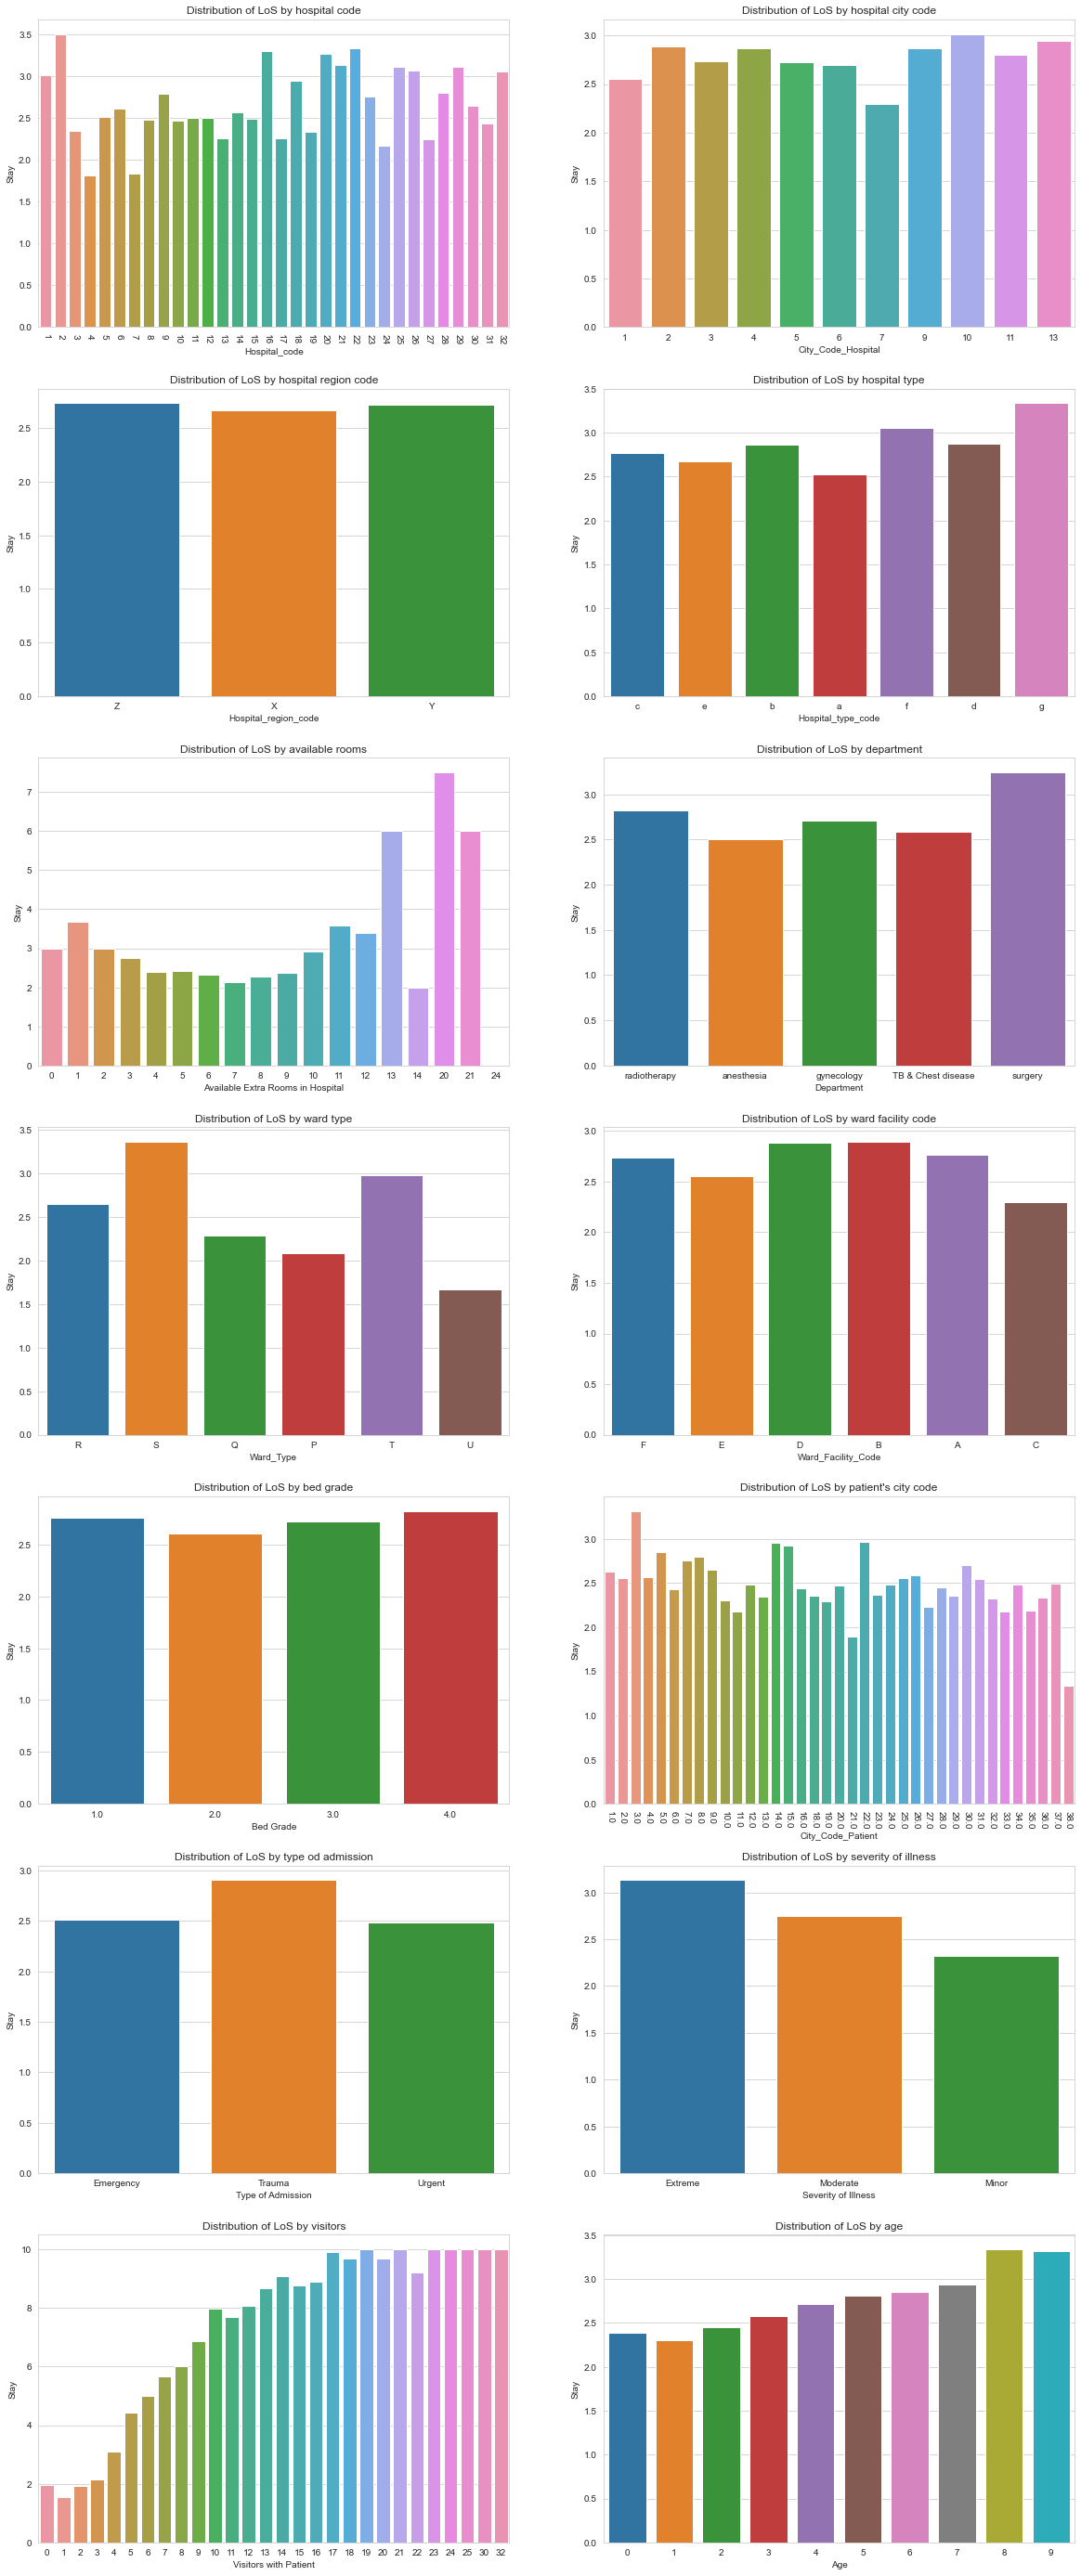

In [17]:
plt.figure(figsize=(20,50))
plt.subplot(7,2,1)
sns.barplot(y= train_data['Stay'], x = train_data['Hospital_code'], ci=None).set_title("Distribution of LoS by hospital code")
plt.xticks(rotation=-90)
plt.subplot(7,2,2)
sns.barplot(y= train_data['Stay'], x = train_data['City_Code_Hospital'], ci=None).set_title("Distribution of LoS by hospital city code")
plt.subplot(7,2,3)
sns.barplot(y= train_data['Stay'], x = train_data['Hospital_region_code'], ci=None).set_title("Distribution of LoS by hospital region code")
plt.subplot(7,2,4)
sns.barplot(y= train_data['Stay'], x = train_data['Hospital_type_code'], ci=None).set_title("Distribution of LoS by hospital type")
plt.subplot(7,2,5)
sns.barplot(y= train_data['Stay'], x = train_data['Available Extra Rooms in Hospital'], ci=None).set_title("Distribution of LoS by available rooms")
plt.subplot(7,2,6)
sns.barplot(y= train_data['Stay'], x = train_data['Department'], ci=None).set_title("Distribution of LoS by department")
plt.subplot(7,2,7)
sns.barplot(y= train_data['Stay'], x = train_data['Ward_Type'], ci=None).set_title("Distribution of LoS by ward type")
plt.subplot(7,2,8)
sns.barplot(y= train_data['Stay'], x = train_data['Ward_Facility_Code'], ci=None).set_title("Distribution of LoS by ward facility code")
plt.subplot(7,2,9)
sns.barplot(y= train_data['Stay'], x = train_data['Bed Grade'], ci=None).set_title("Distribution of LoS by bed grade")
plt.subplot(7,2,10)
sns.barplot(y= train_data['Stay'], x = train_data['City_Code_Patient'], ci=None).set_title("Distribution of LoS by patient's city code")
plt.xticks(rotation=-90)
plt.subplot(7,2,11)
sns.barplot(y= train_data['Stay'], x = train_data['Type of Admission'], ci=None).set_title("Distribution of LoS by type od admission")
plt.subplot(7,2,12)
sns.barplot(y= train_data['Stay'], x = train_data['Severity of Illness'], ci=None).set_title("Distribution of LoS by severity of illness")
plt.subplot(7,2,13)
sns.barplot(y= train_data['Stay'], x = train_data['Visitors with Patient'], ci=None).set_title("Distribution of LoS by visitors")
plt.subplot(7,2,14)
sns.barplot(y= train_data['Stay'], x = train_data['Age'], ci=None).set_title("Distribution of LoS by age")

Text(0.5, 1.0, 'Distribution of LoS by admission deposit')

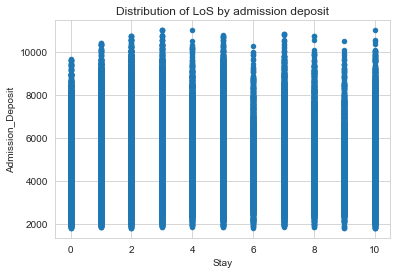

In [18]:
train_data.plot.scatter(y = 'Admission_Deposit', x='Stay').set_title("Distribution of LoS by admission deposit")

As expected patients who are older, suffer from more severe injuries and have more visitors stay in hospitals for longer periods of time. If I had to choose features for a linear regression, these would be the ones I would choose. However, we'll be using random forests, a far more powerful algorithm, therefore we'll use all features available. Since the admission deposit is only the first deposit it isn't as good of a feature as one could have thought. Now it's time to create our model and training and test datasets. But before we get to that let's convert remaining non numeric values into numeric ones.

In [19]:
model_data = train_data
#Hospital type code
values = list(model_data.Hospital_type_code.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Hospital_type_code', values, newCat)

#Hospital region code
values = list(model_data.Hospital_region_code.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Hospital_region_code', values, newCat)

#Department
values = list(model_data.Department.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Department', values, newCat)

#Ward type
values = list(model_data.Ward_Type.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Ward_Type', values, newCat)

#Ward code
values = list(model_data.Ward_Facility_Code.unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Ward_Facility_Code', values, newCat)

#Type of admission
values = list(model_data['Type of Admission'].unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Type of Admission', values, newCat)

#Severity of illness
values = list(model_data['Severity of Illness'].unique())
values.sort()
newCat = list(range(0,len(values)))
categoryConverter(model_data, 'Severity of Illness', values, newCat)



In [20]:
model_data.dtypes
model_data.dropna(inplace=True)
model_data.isna().any()

case_id                              False
Hospital_code                        False
Hospital_type_code                   False
City_Code_Hospital                   False
Hospital_region_code                 False
Available Extra Rooms in Hospital    False
Department                           False
Ward_Type                            False
Ward_Facility_Code                   False
Bed Grade                            False
patientid                            False
City_Code_Patient                    False
Type of Admission                    False
Severity of Illness                  False
Visitors with Patient                False
Age                                  False
Admission_Deposit                    False
Stay                                 False
dtype: bool

### Splitting the dataset and creating the model ###
First we'll split the train_data using sklearn. Then we'll create a random forest with random hyperparameter values, we'll train and evaluate it, and then we'll move to hyperregulation.

In [21]:
train = model_data.drop(columns=['Stay'])
labels = model_data['Stay'].astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(train, labels, random_state=101, test_size=0.2, shuffle=True)

In [26]:
#Create a model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.41793208942143756


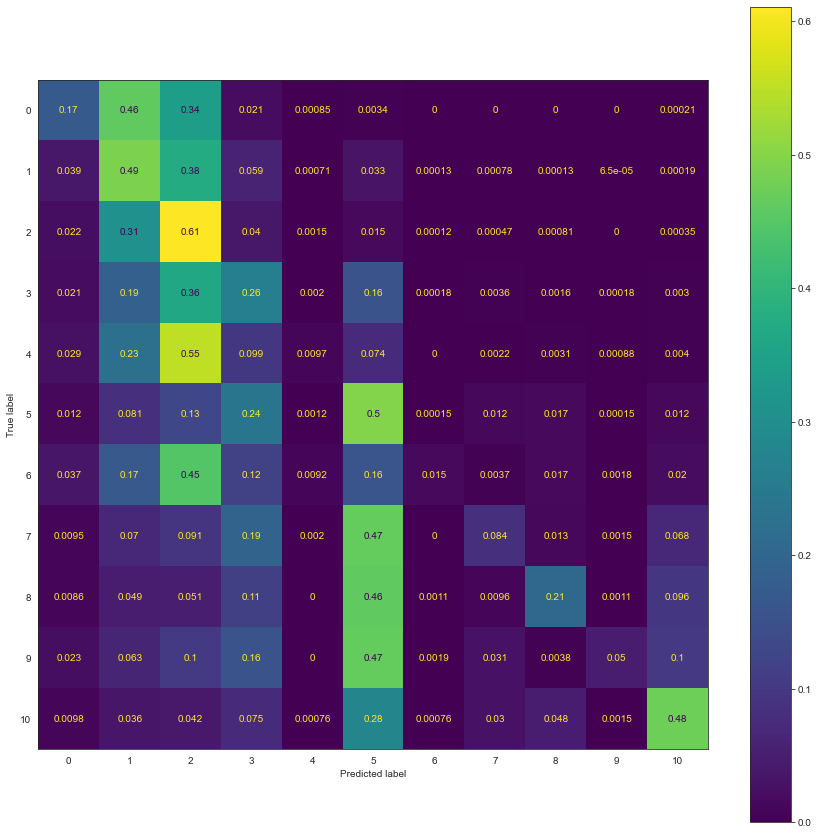

In [27]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(clf, X_test, Y_test,normalize='true',ax=ax)

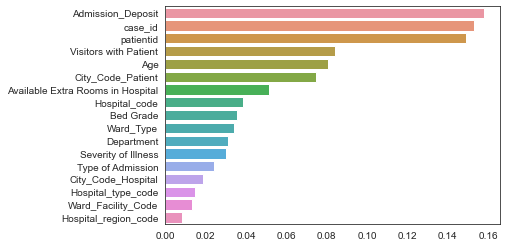

In [28]:
#Visualization of feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

As we can see on the graph above, the 5 most important features were:
* Admission deposit
* Case ID
* Patient ID
* Visitors with patient
* Age

While some of these are understandable, the case ID is definitely a surprisingly important feature. However, the model achieves only 41,5% accuracy, which is hardly satisfying. Let's try performing cross validation on some of its parameters and then we'll see if better accuracy can be achieved. I have chosen a few (usually) most important hyperparameters to tune.

In [29]:
### WARNING: This code takes a long time to run, therefore after running it I saved the best model, commented out the code
### and ran it again. The best model is in the cell below.
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [50, 80, 100, 120, 150],
#     'max_features': [2,3,4],
#     'min_samples_leaf': [2, 5, 8],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [50, 100, 200, 500, 1000]
# }
# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train,Y_train)
# best params = grid_search.best_params_
# best_model = grid_search.best_estimator_

Best model found by the cross validation was: RandomForestClassifier(max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=1000)

In [32]:
rf = RandomForestClassifier(max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=1000)
rf.fit(X_train,Y_train)
Y_pred=rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.4285281792252904


As we can see, the accuracy did increase, however only slightly. The prediciton is still wrong more often than right, so I will try another approach to the problem. So before the end I'll simply export the processed training-ready data to a csv.

In [ ]:
model_data.to_csv('processed_data.csv')